In [1]:
import psycopg2
from collections import defaultdict

In [58]:
import os, json
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import LogisticRegression
import matplotlib.dates as dates
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

class Analyse:
    def startAnalyse(df, countries, yLabel, yColumn):
        df = df[(df["Value"]>0)] #suppress data with no cases (before begin of epidemy)
        X = {}
        convertedX = {}
        y = {}
        y_log = {}
        regressor = {}
        model = {}
        r_sq = {}
        X_pred = {}
        y_pred = {}
        y_SEIR = {}
        
        coeff = {}
        dailyCoeff = {}
        
        output = {'Italy': {}, 'France': {}, 'Germany': {}}

        for country in countries:
            # Select data
            X[country] = df[df["Country/Region"]==country][["update"]].copy()
            convertedX[country] = X[country].copy()
            convertedX[country]["update"] = convertedX[country]["update"].astype(int)
            ## for backwards conversion to datetime: pd.to_datetime(X["update"].astype(int))
            y[country] = df[df["Country/Region"]==country][yColumn]
            y_log[country] = np.log(df[df["Country/Region"]==country][yColumn])
            # Create model
            regressor[country] = LinearRegression()
            model[country] = regressor[country].fit(convertedX[country], y_log[country])
            r_sq[country] = model[country].score(convertedX[country], y_log[country])
            coeff[country] = regressor[country].coef_[0]
            dailyCoeff[country] = round(10**(3600*24*(10**9)*regressor[country].coef_[0]), 1)
            #print(country)
            #print('intercept:', model[country].intercept_)
            #print('slope:', model[country].coef_[0])

            # Generate prediction: regressor.predict(convertedX)
            X_pred[country] = pd.DataFrame([
                X[country].min(), 
                X[country].min() + pd.Timedelta(1, unit='d'), 
                X[country].min() + pd.Timedelta(2, unit='d'), 
                X[country].min() + pd.Timedelta(3, unit='d'), 
                X[country].min() + pd.Timedelta(4, unit='d'), 
                X[country].min() + pd.Timedelta(5, unit='d'), 
                X[country].min() + pd.Timedelta(6, unit='d'), 
                X[country].min() + pd.Timedelta(7, unit='d'),
                X[country].max() + pd.Timedelta(1, unit='d'),
                X[country].max() + pd.Timedelta(2, unit='d'),
                X[country].max() + pd.Timedelta(3, unit='d'),
                X[country].max() + pd.Timedelta(4, unit='d'),
                X[country].max() + pd.Timedelta(5, unit='d'),
                X[country].max() + pd.Timedelta(6, unit='d'),
                X[country].max() + pd.Timedelta(7, unit='d'),
                X[country].max() + pd.Timedelta(8, unit='d'),
                X[country].max() + pd.Timedelta(9, unit='d'),
                X[country].max() + pd.Timedelta(10, unit='d'),
                X[country].max() + pd.Timedelta(11, unit='d'),
                X[country].max() + pd.Timedelta(12, unit='d'),
                X[country].max() + pd.Timedelta(13, unit='d'),
                X[country].max() + pd.Timedelta(14, unit='d')])
            y_pred[country] = np.exp(regressor[country].predict(X_pred[country].astype(int)))
            
            
        # Plot result
        fig, ax = plt.subplots(ncols=1, nrows=1)
        ax.set_yscale("log")
        #ax.set_ylim(1,10000)

        ax.grid(True, which="minor", axis="y", color='g', linestyle='--', linewidth=1,alpha=0.3)
        ax.grid(True, which="major", axis="y", color='g', linestyle='-', linewidth=2,alpha=0.3)

        ax.xaxis.set_minor_locator(dates.DayLocator(bymonthday=range(1,32), interval=1))
        ax.xaxis.set_minor_formatter(dates.DateFormatter('%d'))
        ax.xaxis.set_major_locator(dates.WeekdayLocator(byweekday=0))
        ax.xaxis.set_major_formatter(dates.DateFormatter('\n%m-%d'))
        ax.grid(True, which="major", axis="x", color='g', linestyle='-', linewidth=2)
        fig.set_size_inches(20,5)
        for country in countries:
            plotDf = pd.DataFrame(X[country])
            
            
            plotDf["y"]=y[country]
            plotDf.plot(x="update", y="y", ax=ax, style="o:", label="act "+country)     
            
            
            plotDf_pred = pd.DataFrame(X_pred[country])
            plotDf_pred["y"]=y_pred[country]
            plotDf_pred.plot(x="update", y="y", ax=ax, style="--", label="pred "+country)
            #plt.plot(X[country], y[country], "ro")
            #plt.plot(X_pred[country][["update"]], y_pred[country], "b--")
            plotDf.set_index('update', inplace=True)
            plotDf_pred.set_index('update', inplace=True)
            #plotDf['predicted'] = plotDf_pred['y']
            #output[country]['real_value'] = plotDf
            #output[country]['predicted_value'] = plotDf_pred
            plotDf_pred.rename(columns={'y': 'predicted'}, inplace=True)
            output[country] = pd.merge(plotDf, plotDf_pred, on='update', how='outer').reset_index()
            
           
        plt.title('prediction')
        plt.xlabel('datetime')
        plt.ylabel(yLabel)
        plt.legend()
        plt.show()

        print('Coefficient of determination:', r_sq)
        print("Evolution factor per day: {}".format(dailyCoeff))
        #print("Evolution factor per 2 days: {}".format(round(10**(3600*24*2*(10**9)*regressor[country].coef_[0]), 1)))
        #print("Evolution factor per 3 days: {}".format(round(10**(3600*24*3*(10**9)*regressor[country].coef_[0]), 1)))
        #print("Evolution factor per week: {}".format(round(10**(3600*24*7*(10**9)*regressor[country].coef_[0]), 1)))
        #X_pred[country]["pred"] = pd.DataFrame(y_pred[country])
        #X_pred[country]["prev"] = X_pred[country].apply(
        #    lambda row: X_pred[country][X_pred[country]["update"]<row["update"]]["update"].max(), 
        #    axis=1
        #)
        #X_pred[country]["diff"] = X_pred[country].apply(
        #    lambda row: row["pred"] / X_pred[country][X_pred[country]["update"]==row["prev"]]["pred"].max(), 
        #    axis=1
        #)
        return output

In [59]:
import requests
import io

# Load data from url
def loadData(url):
    urlData = requests.get(url).content
    return pd.read_csv(io.StringIO(urlData.decode('utf-8')))
# Pivoting
def Pivot(df):
    # Exclude outside Europe
    df = df[
        (df["Lat"]>40) & (df["Lat"]<55)
        & (df["Long"]>0) & (df["Long"]<27)
    ]
    df = df.set_index(["Province/State", "Country/Region","Lat","Long"])
    df = df.stack().reset_index().rename(
        columns={"level_4":"Date",0:"Value"}
    )
    df["update"] = pd.to_datetime(df["Date"])
    maxDate = df["update"].max()
    df = df[
        (df["update"]>maxDate - pd.Timedelta(days=60))
    ]
    return df[df["Value"]>0][["Country/Region","update","Value"]]

In [60]:
base_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/"
confirmedUrl = "time_series_19-covid-Confirmed.csv"
deathsUrl = "time_series_19-covid-Deaths.csv"
recoveredUrl = "time_series_19-covid-Recovered.csv"

countriesSelected = ["Italy","France","Germany"]

In [61]:
confirmedDf = loadData(base_url+confirmedUrl)
deathsDf = loadData(base_url+deathsUrl)
recoveredDf = loadData(base_url+recoveredUrl)

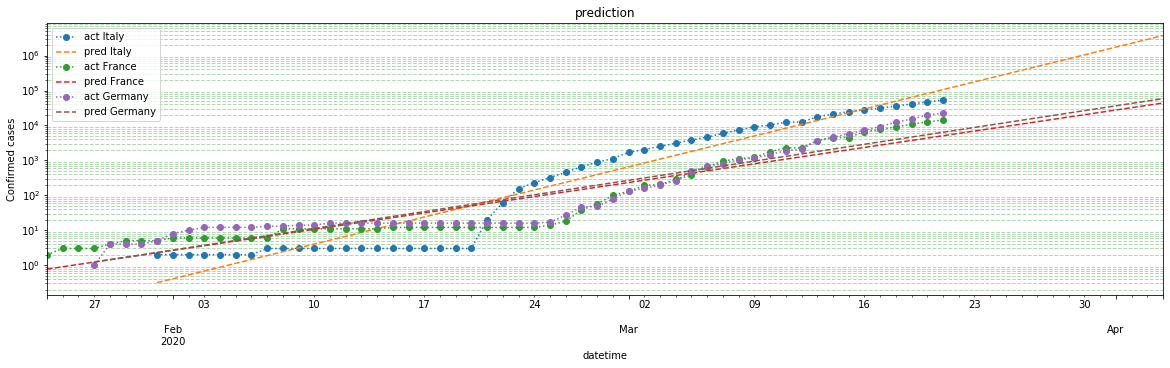

Coefficient of determination: {'Italy': 0.9277078622071253, 'France': 0.8785059427162796, 'Germany': 0.8777177210364107}
Evolution factor per day: {'Italy': 1.8, 'France': 1.4, 'Germany': 1.4}


In [119]:
output = Analyse.startAnalyse(
    Pivot(confirmedDf),
    countriesSelected,
    "Confirmed cases", 
    "Value"
)

In [123]:
pd.set_option('display.max_rows', 100)

In [124]:
output['Germany'].head(100)

,update,y,predicted
0,2020-01-27,1.0,1.223919
1,2020-01-28,4.0,1.434093
2,2020-01-29,4.0,1.680359
3,2020-01-30,4.0,1.968914
4,2020-01-31,5.0,2.307021
5,2020-02-01,8.0,2.703188
6,2020-02-02,10.0,3.167386
7,2020-02-03,12.0,3.711297
8,2020-02-04,12.0,NaN
9,2020-02-05,12.0,NaN


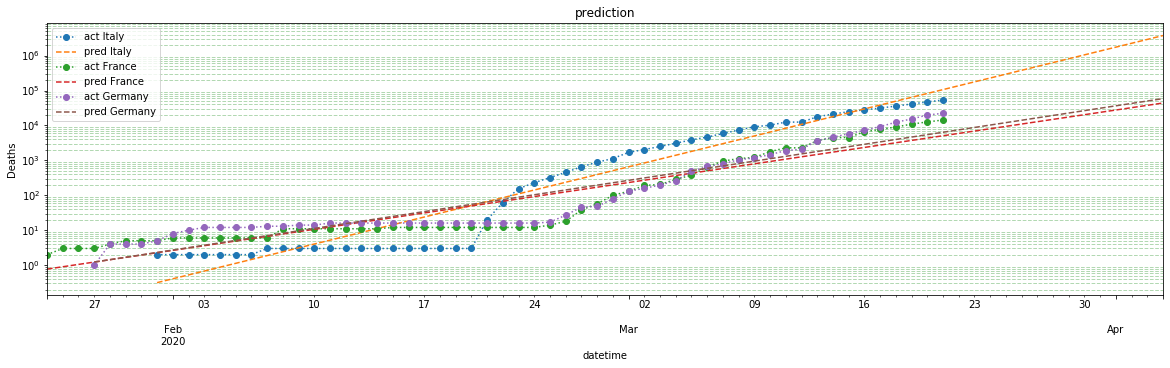

Coefficient of determination: {'Italy': 0.9277078622071253, 'France': 0.8785059427162796, 'Germany': 0.8777177210364107}
Evolution factor per day: {'Italy': 1.8, 'France': 1.4, 'Germany': 1.4}


In [63]:
output = Analyse.startAnalyse(
    Pivot(confirmedDf),
    countriesSelected,
    "Deaths", 
    "Value"
)

In [66]:
output['Germany'].head(100)

,update,y,predicted
0,2020-01-27,1.0,1.223919
1,2020-01-28,4.0,1.434093
2,2020-01-29,4.0,1.680359
3,2020-01-30,4.0,1.968914
4,2020-01-31,5.0,2.307021
...,...,...,...
64,2020-03-31,NaN,31083.937912
65,2020-04-01,NaN,36421.747152
66,2020-04-02,NaN,42676.177947
67,2020-04-03,NaN,50004.634774


In [97]:
connection.rollback()

In [93]:
connection = psycopg2.connect(user="avnadmin",
                                  password="thnj5za8epyddkxt",
                                  host="pg-e2cae57-icslecture-9af5.aivencloud.com",
                                  port="19745",
                                  database="results")

In [94]:
cur = connection.cursor()

In [72]:
cur.execute("DROP TABLE regression;")

In [98]:
table_str = """
    CREATE TABLE regression_v3 (
    date DATE NOT NULL,
    data_type VARCHAR(255) NOT NULL,
    country VARCHAR(255) NOT NULL,
    actual_value DECIMAL,
    predicted_value DECIMAL)
"""

In [71]:
cur.commit()

AttributeError: 'psycopg2.extensions.cursor' object has no attribute 'commit'

In [99]:
cur.execute(table_str)

In [100]:
connection.commit()

In [101]:
connection.close()

In [111]:
connection = psycopg2.connect(user="avnadmin",
                                  password="thnj5za8epyddkxt",
                                  host="pg-e2cae57-icslecture-9af5.aivencloud.com",
                                  port="19745",
                                  database="results")

In [112]:
cur = connection.cursor()

In [116]:
cur.execute("""select * from regression_v3""")

In [118]:
cur.fetchone()

(datetime.date(2020, 1, 31),
 'Confirmed cases',
 'Italy',
 Decimal('2.0'),
 Decimal('0.3151443203850963'))

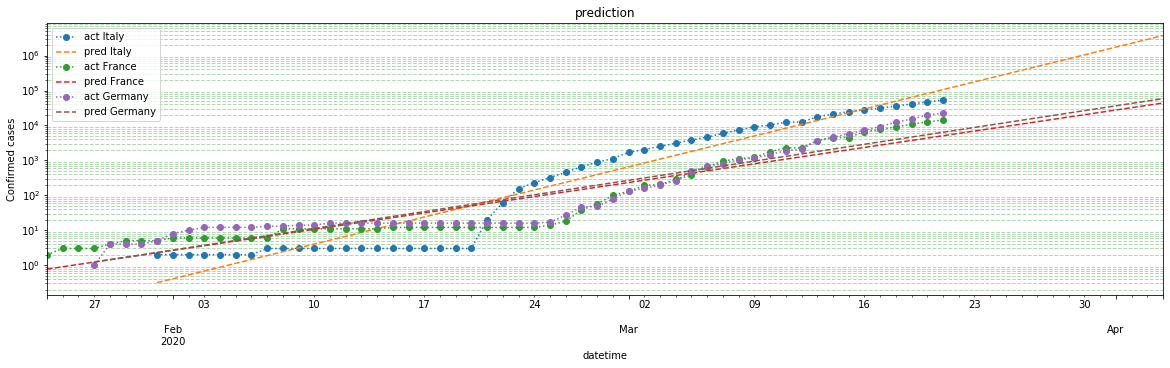

Coefficient of determination: {'Italy': 0.9277078622071253, 'France': 0.8785059427162796, 'Germany': 0.8777177210364107}
Evolution factor per day: {'Italy': 1.8, 'France': 1.4, 'Germany': 1.4}


In [104]:
output = Analyse.startAnalyse(
    Pivot(confirmedDf),
    countriesSelected,
    "Confirmed cases", 
    "Value"
)

In [105]:
for country in output.keys():
    data = output[country]
    for row in data.iterrows():
        date = row[1][0]
        y = row[1][1]
        pred = row[1][2]
        query = """INSERT INTO regression_v3 (date,
                                    data_type,
                                    country,
                                    actual_value,
                                    predicted_value) VALUES (%s,%s,%s,%s,%s)"""
        values = (date, 'Confirmed cases', country, y, pred)
        cur.execute(query, values)
        connection.commit()

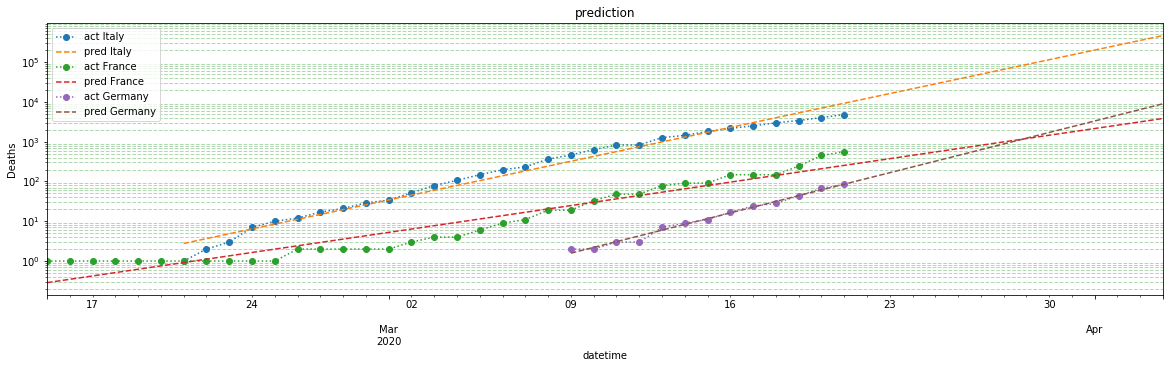

Coefficient of determination: {'Italy': 0.9782559086846383, 'France': 0.9265542428465746, 'Germany': 0.9875038291316265}
Evolution factor per day: {'Italy': 1.9, 'France': 1.6, 'Germany': 2.2}


In [106]:
output = Analyse.startAnalyse(
    Pivot(deathsDf),
    countriesSelected,
    "Deaths", 
    "Value"
)

In [107]:
for country in output.keys():
    data = output[country]
    for row in data.iterrows():
        date = row[1][0]
        y = row[1][1]
        pred = row[1][2]
        query = """INSERT INTO regression_v3 (date,
                                    data_type,
                                    country,
                                    actual_value,
                                    predicted_value) VALUES (%s,%s,%s,%s,%s)"""
        values = (date, 'Deaths', country, y, pred)
        cur.execute(query, values)
        connection.commit()

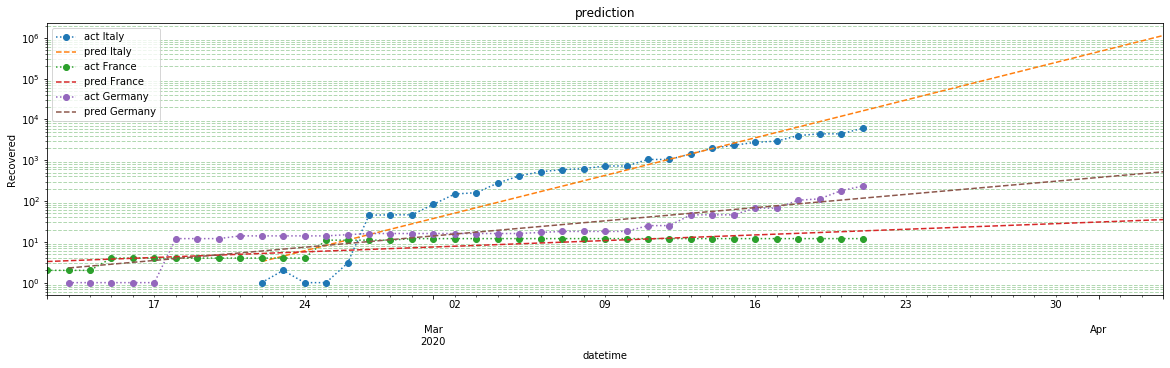

Coefficient of determination: {'Italy': 0.8834556407949635, 'France': 0.7011579010434751, 'Germany': 0.7724157012173138}
Evolution factor per day: {'Italy': 2.0, 'France': 1.1, 'Germany': 1.3}


In [108]:
output = Analyse.startAnalyse(
    Pivot(recoveredDf),
    countriesSelected,
    "Recovered", 
    "Value"
)

In [109]:
for country in output.keys():
    data = output[country]
    for row in data.iterrows():
        date = row[1][0]
        y = row[1][1]
        pred = row[1][2]
        query = """INSERT INTO regression_v3 (date,
                                    data_type,
                                    country,
                                    actual_value,
                                    predicted_value) VALUES (%s,%s,%s,%s,%s)"""
        values = (date, 'Recovered', country, y, pred)
        cur.execute(query, values)
        connection.commit()

In [110]:
connection.close()

In [125]:
connection = psycopg2.connect(user="avnadmin",
                                  password="thnj5za8epyddkxt",
                                  host="pg-e2cae57-icslecture-9af5.aivencloud.com",
                                  port="19745",
                                  database="results")

In [126]:
cur = connection.cursor()

In [127]:
cur.execute("DROP TABLE country_map;")

In [128]:
cur.execute("""CREATE TABLE country_map (
    country VARCHAR(255) NOT NULL,
    country_code VARCHAR(255) NOT NULL)""")

In [129]:
connection.commit()

In [130]:
italy_query = """INSERT INTO country_map (
                                    country,
                                    country_code) VALUES (%s, %s)"""
italy_values = ('Italy', 'IT')
cur.execute(italy_query, italy_values)
connection.commit()

In [131]:
france_query = """INSERT INTO country_map (
                                    country,
                                    country_code) VALUES (%s, %s)"""
france_values = ('France', 'FR')
cur.execute(france_query, france_values)
connection.commit()

In [132]:
germany_query = """INSERT INTO country_map (
                                    country,
                                    country_code) VALUES (%s, %s)"""
germany_values = ('Germany', 'DE')
cur.execute(germany_query, germany_values)
connection.commit()

In [133]:
connection.close()